# Анализ трековых данных воздушных судов

Краткое описание
Разработка ПО способного находить аномалии в треках воздушных судов.
Текущая ситуация
Система организации воздушного движения (ОрВД) – сложная система с множеством участников, среди которых: авиакомпании, диспетчеры управления воздушным движением, аэропорты, провайдеры аэронавигационных услуг, авиационные власти и др. Каждый из участников системы ОрВД имеет свои цели и интересы. Кроме того, функционирование системы ОрВД должно отвечать множеству критериев, таких как безопасность воздушного движения, пропускная способность, пунктуальность, экономическая эффективность, влияние на окружающую среду и многое другое. 
Исследование и оптимизация системы ОрВД представляет собой очень важную и одновременно сложную задачу. Для многих исследовательских задач необходима большая выборка исторических трековых данных, полученных по радарным наблюдениям воздушных судов. Данные должны быть пригодны для исследований и отвечать требованиям по качеству, однако в них нередко могут встречаться ошибки разного рода. Задача определения треков воздушных судов, содержащих ошибки, является предварительной задачей к проведению исследований, а также разработке интеллектуальных систем поддержки системы ОрВД.
Проблема
Заданы два текстовых файла, содержащих трековые данные воздушных судов, выполняющих полет в воздушном пространстве РФ. Файл Х содержит трековые данные нормального качества, подходящие для дальнейшего использования (Х треков). Файл Y содержит трековые данные с ошибками разного рода (Х треков). Встречаются следующие типы ошибок:
- «Скачки по высоте»
- «Скачки по широте и долготе»
- «Неполный трек»
- «Пилообразный трек»
Файлы с трековыми данными имеют следующий формат:
Каждая запись в файле представляет собой трековые данные одного рейса. Трековые данные представлены множеством точек в воздушном пространстве и времени их пролета, то есть представляют собой множество элементов, включающих:
- Широты точки в формате ХХХ;
- Долготы точки в формате ХХХ;
- Высоты точки в ХХХ;
- Времени пролета точки в формате ХХХ.
Для удобства анализа трековых данных прилагается ПО, визуализирующее горизонтальный и вертикальный профиль выбранных треков.
Задача
Требуется построить алгоритм и ПО, способное классифицировать множество поступающих в него трековых данных на два множества – трековые данные, пригодные для дальнейшего использования, и трековые данные с ошибками. 
При формировании алгоритма необходимо использовать набор размеченных (обучающих) треков.
Из заданного набора размеченных трековых данных требуется выделить набор тестовых треков (включающих треки с ошибками и без), на которых необходимо выполнить оценку работоспособности сформированного алгоритма. 

## Мысли по решению

- Вместо координат и точек рассмтреть датасет из (эти признаки намнго информативней просто координат, т.к. отображают именно перемещение):
    - прироста высоты, времени (c учетом возможности перехода из 23:59 -> 00:00 и поломкой всего), расстояния между текущей и предыдущей координатой и угла между текущей и предыдущей координатой,
    - оставить просто высоту (на случай, если колебания высот могут быть важны не только абсолютные)
    - и добавить скорости по осям и общую + ускорения (скорости для эксперимента, возможно дополнить ускорениями и скользящими средними)
    - проверить, стоит ли добавлять абсолютные координаты и не ухудшает ли это качество
- Унифицировать все треки 
    - сделать так, чтобы угол между начальной и конечной точкой везде был одинаковый - так исключится лишняя информация о направлении движения, которая зашумляла данные и еще прога не сможет переобучиться на то, что путь из А в В всегда плохой, а из А в С всегда хороший, даже если так было в обучающих данных 
    - проверить экспериментально, улучшает ли такая унификация качество

- Эксперименты с моделями
    - Рекурентные:
        - Попробовать LSTM/GRU
        - попробовать классифицировать не по последнему скрытому состоянию, а по нему, дополненому пуллингами от всех данных (кроме последнего?)
        - эксперименты с классификатором

    - конволюционные сети:
        - проходимся ядром по найшей последовательности векторов, получая новые представления этой последовательности, так, возможно, несколько раз, а потом херачим пулинг и пихаем в классификатор
    - комбинация обоих методов


## Решение

### Выгрузка данных

Формат данных:
В каждой строке через пробел перечислены следующие данные:

Время, чч:мм:сс

Идентификатор трека (id)

Широта, градусы с десятичной дробной частью

Долгота, градусы с десятичной дробной частью

Высота, м

Код ответчика

Позывной

In [1]:
import pandas as pd
from math import radians

In [91]:
good_tracks = [
               'GoodTracksHackaton1801.txt',
               'GoodTracksHackaton2101.txt',
               'GoodTracksHackaton2301.txt'
               ]
bad_tracks = [
              'BadTracksHackaton1801.txt',
              'BadTracksHackaton2101.txt',
              'BadTracksHackaton2301.txt'
              ]

data = pd.DataFrame()
labels = dict()
for path in (good_tracks + bad_tracks):
    res = pd.read_csv('Data/' + path, sep=' ', encoding='cp1250', header=None)
    res.columns = ['time', 'id', 'lat', 'lon', 'height', 'code', 'name']
    res['id'] = path + '_' + res['id'].astype(str)
    for id in res['id'].unique():
        labels[id] = int(path in bad_tracks)
    res['time'] = pd.to_timedelta(res['time'])
    res['time'] = res['time'].dt.total_seconds()
    
    data = pd.concat([data, res], axis=0)
data = data.sort_values(by=['id', 'time']).reset_index(drop=True)

In [92]:
data.describe()
data.head(5)

time      float64
id         object
lat       float64
lon       float64
height      int64
code      float64
name       object
dtype: object

,time,id,lat,lon,height,code,name
0,26664.0,BadTracksHackaton1801.txt_1000,62.096153,44.322420,0,5754.0,NaN
1,26670.0,BadTracksHackaton1801.txt_1000,62.091250,44.294145,10965,5754.0,NaN
2,26673.0,BadTracksHackaton1801.txt_1000,62.088000,44.276689,10965,5754.0,NaN
3,26681.0,BadTracksHackaton1801.txt_1000,62.081171,44.244626,10965,5754.0,NaN
4,26683.0,BadTracksHackaton1801.txt_1000,62.079331,44.236134,10965,5754.0,NaN


### Анализ данных

Этапы анализа:
- Без выгрузки данных:
    - Прочитали описание возможных ошибок
    - Посмотрели глазами на треки на Google Earth
- С выгрузкой:
    - Посмотрели на формат данных
    - заметили, что данные упорядочены по времени и время начинается с нуля - кул (правда, не факт, что везде так хорошо)
    <!-- - заметили, что время может перескакивать через 00:00 (есть 23:59 в данных) - плохо, надо добавлять день -->
    - посмотрим на распределение времени

<AxesSubplot:>

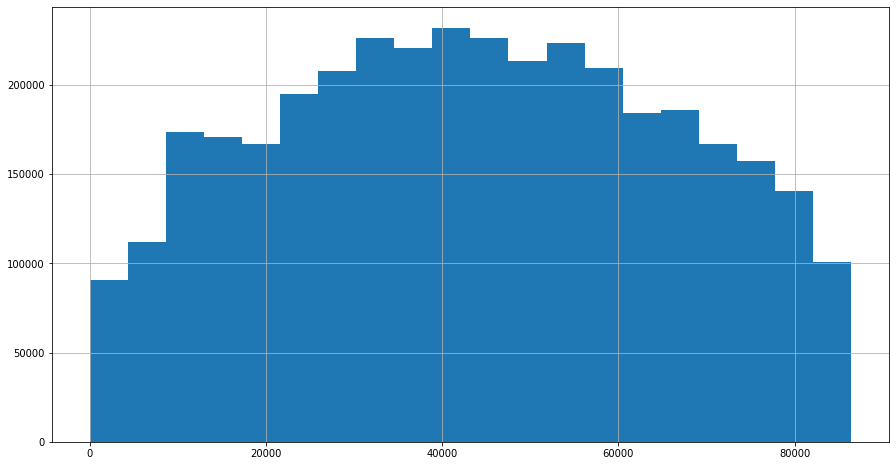

In [93]:
data['time'].hist(bins=20, figsize=(15, 8))

Выглядит вполне адекватно кроме странного горба слева

Разобьем данные на трейн и тест:

In [94]:
from random import sample, choices

In [95]:
ids = set(data['id'].unique())
print(len(ids))

test_part = 0.2

good_ids = [id for id in ids if not labels[id]]
bad_ids = [id for id in ids if labels[id]]

good_size = len(good_ids)
bad_size = len(bad_ids)

test_ids = set(choices(good_ids, k=int(good_size * test_part)) + choices(bad_ids, k=int(bad_size * test_part)))
train_ids = [id for id in ids if id not in test_ids]

6778


Теперь сгенерируем признаки, которые хотели:

Тут добавим перемещение и угол

In [96]:
from math import sin, cos, atan, pi, radians
# тут позволяем первым точкам каждого из id, кроме первого иметь некорректное 
# значение (разница с другим id), т.к. первые точки мы удалим все равно

lon2 = data['lon'].apply(radians)
lon1 = data.groupby('id')['lon'].shift(1).apply(radians)
dlon = (lon2 - lon1)

lat2 = data['lat'].apply(radians)
lat1 = data.groupby('id')['lat'].shift(1).apply(radians)

dlat = lat2 - lat1

y = dlon.apply(sin) * lat2.apply(cos)
x = lat1.apply(cos) * lat2.apply(sin) \
- lat1.apply(sin) * lat2.apply(cos) * dlon.apply(cos)

data['angle'] = (y /x).apply(atan)
data['angle'] = (data['angle'] + pi) % pi


a = (dlat / 2).apply(sin)**2 + lat1.apply(cos) * lat2.apply(cos) * (dlon / 2).apply(sin)**2
data['dist'] = 2 * (a**(1/2) / (1 - a)**(1/2)).apply(atan)

Traceback (most recent call last):
  File "/kernel/lib/python3.7/site-packages/ml_kernel/state/state_protocol.py", line 287, in _load_component
    value = unpickler.load()
  File "/usr/local/lib/python3.7/dist-packages/torch/storage.py", line 142, in _load_from_bytes
    return torch.load(io.BytesIO(b))
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 585, in load
    return _legacy_load(opened_file, map_location, pickle_module, **pickle_load_args)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 765, in _legacy_load
    result = unpickler.load()
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 721, in persistent_load
    deserialized_objects[root_key] = restore_location(obj, location)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 174, in default_restore_location
    result = fn(storage, location)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", lin

In [97]:
from tqdm.notebook import tqdm

shift_cols = ['height', 'time']
for col in shift_cols:
    data[col + '_diff'] = data[col] - data.groupby('id')[col].shift(1)
    
# data.head()

,time,id,lat,lon,height,code,name,angle,dist,height_diff,time_diff
0,26664.0,BadTracksHackaton1801.txt_1000,62.096153,44.322420,0,5754.0,NaN,NaN,NaN,NaN,NaN
1,26670.0,BadTracksHackaton1801.txt_1000,62.091250,44.294145,10965,5754.0,NaN,1.216195,0.000246,10965.0,6.0
2,26673.0,BadTracksHackaton1801.txt_1000,62.088000,44.276689,10965,5754.0,NaN,1.192366,0.000153,0.0,3.0
3,26681.0,BadTracksHackaton1801.txt_1000,62.081171,44.244626,10965,5754.0,NaN,1.144091,0.000288,0.0,8.0
4,26683.0,BadTracksHackaton1801.txt_1000,62.079331,44.236134,10965,5754.0,NaN,1.137457,0.000076,0.0,2.0


Удаляем лишние колонки и строоки с None в важных признаках

In [98]:
data = data.drop(columns=['time', 'lat', 'lon', 'code', 'name']).dropna()

In [99]:
def clean(data, cols):
    for col in cols:
        data.loc[data['time_diff'] == 0, col] = None
        data.loc[data[col].isnull(), col] = data[col].mean(axis=0)
        yield data[col]

data['speed'] = data['dist'] / data['time_diff']
data['accel'] = (data['speed'] - data['speed'].shift(1)) / data['time_diff']
cols = ['accel', 'speed']
for i, res in enumerate(clean(data, cols)):
    data[cols[i]] = res
data.head(5)

,id,height,angle,dist,height_diff,time_diff,speed,accel
1,BadTracksHackaton1801.txt_1000,10965,1.216195,0.000246,10965.0,6.0,0.000041,-inf
2,BadTracksHackaton1801.txt_1000,10965,1.192366,0.000153,0.0,3.0,0.000051,0.000003
3,BadTracksHackaton1801.txt_1000,10965,1.144091,0.000288,0.0,8.0,0.000036,-0.000002
4,BadTracksHackaton1801.txt_1000,10965,1.137457,0.000076,0.0,2.0,0.000038,0.000001
5,BadTracksHackaton1801.txt_1000,10965,1.112719,0.000129,0.0,4.0,0.000032,-0.000002


In [100]:
min_value = data['accel'].min()
data.loc[data['accel'] == min_value, 'accel'] = data.loc[data['accel'] != min_value, 'accel'].min()
# data.loc[data['accel'] == min_val, 'accel'] = data.loc[data['accel'] != min_value, 'accel'].min()

Нормировка данных. Нельзя просто поделить на максимум - плохие треки имеют выбросы и они зануляют остальную статистику при делении на их модуль (т.к. очень велики).

(Не повернул треки, пока не знаю, стоит ли и как это сделать.)

Много выбросов везде, постараемся отфильтровать данные:

In [102]:
from matplotlib import pyplot as plt

In [105]:
import pandas as pd
from sklearn import preprocessing

x = data.drop(columns=['id']).values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
cols = [col for col in data.columns if col != 'id']
data = data.reset_index(drop=True)
data.loc[:, cols] = pd.DataFrame(x_scaled, columns=cols)
# data.loc[:, cols] -= data.loc[:, cols].mean(axis=0)
# data.loc[:, cols] /= 2

data.sample(5)

,id,height,angle,dist,height_diff,time_diff,speed,accel
494552,BadTracksHackaton1801.txt_582,0.486965,0.239708,0.000981,0.494523,0.000118,0.004316,0.231924
1838740,GoodTracksHackaton1801.txt_1590,0.309988,0.803047,0.000598,0.494523,0.000130,0.002392,0.231818
1279587,BadTracksHackaton2301.txt_1524,0.446685,0.423821,0.001232,0.494523,0.000118,0.005417,0.231969
1954175,GoodTracksHackaton1801.txt_2309,0.514056,0.859647,0.000497,0.494523,0.000059,0.004377,0.232033
1307007,BadTracksHackaton2301.txt_1705,0.411156,0.702507,0.000279,0.495196,0.000024,0.006146,0.233906


In [142]:
from sklearn.externals import joblib 

joblib.dump(min_max_scaler, './Models/scaler.pkl')

['./Models/scaler.pkl']

In [212]:
data_dict = {id: data[data['id'] == id].drop(columns='id').values for id in data['id'].unique()}

### Построение модели

In [216]:
#!g1.4


import importlib
import utils
importlib.reload(utils)
input_size = len(data.columns) - 1
        

X_test, y_test, sizes_test = utils.data_converter(test_ids, data_dict, 'cuda', labels, verbose=True)

from matplotlib import pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import accuracy_score

In [256]:
#!g1.4
from random import choices
import numpy as np

model = utils.net()
device = 'cuda'
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss = nn.CrossEntropyLoss()

In [257]:
#!g1.4
train_loss = []
test_loss = []
train_acc = []
test_acc = []

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


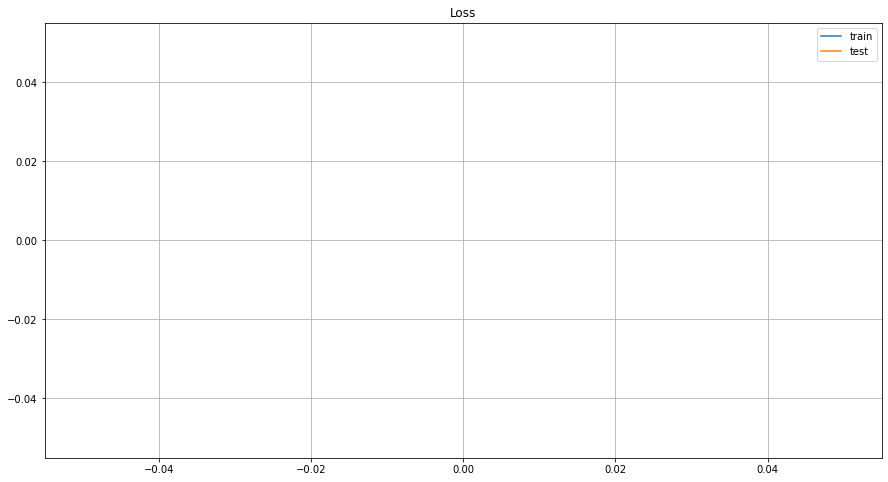

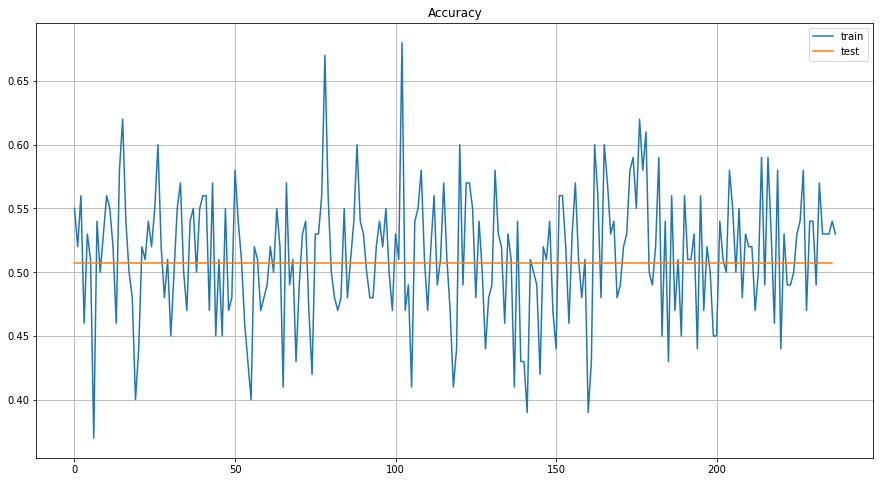

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: f
  warnings.warn(message)


KeyboardInterrupt: 

In [261]:
#!g1.4

importlib.reload(utils)
from time import time

batch_size = 100
iterations = len(train_ids) // batch_size

n_epochs = 20

times = []

model.train()
for epoch in tqdm(range(n_epochs)):
    for i in range(iterations):
        start = time()
        print(i, end='\r')
        optimizer.zero_grad()
        batch_id = choices(list(train_ids), k=batch_size)
        X, y, sizes = utils.data_converter(batch_id, data_dict, 'cuda', labels)
        y_pred = model.forward(X, sizes).squeeze()

        loss_value = loss(y_pred, y)
        train_loss.append(loss_value)
        train_acc.append(accuracy_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy().argmax(axis=1)))
        loss_value.backward()
        optimizer.step()
        with torch.no_grad():
            y_test_pred = model.forward(X_test, sizes_test).squeeze()
            loss_value = loss(y_test_pred, y_test)
            test_loss.append(loss_value)
            test_acc.append(accuracy_score(y_test.cpu().detach().numpy(), y_test_pred.cpu().detach().numpy().argmax(axis=1)))


        if (i + 1) % 15 == 0:
            clear_output(wait=True)
            print(train_loss[-1])
            plt.figure(figsize=(15, 8))
            plt.plot(train_loss, label='train')
            plt.plot(test_loss, label='test')
            plt.legend()
            plt.grid()
            plt.title('Loss')
            plt.figure(figsize=(15, 8))
            plt.plot(train_acc, label='train')
            plt.plot(test_acc, label='test')
            plt.legend()
            plt.grid()
            plt.title('Accuracy')
            plt.show()
        path = f'./Models/classifier_{len(train_loss)}'
        with open (path, 'wb') as f:
            torch.save(model.state_dict(), f)
        torch.cuda.empty_cache()
        end = time()
        times.append(end - start)


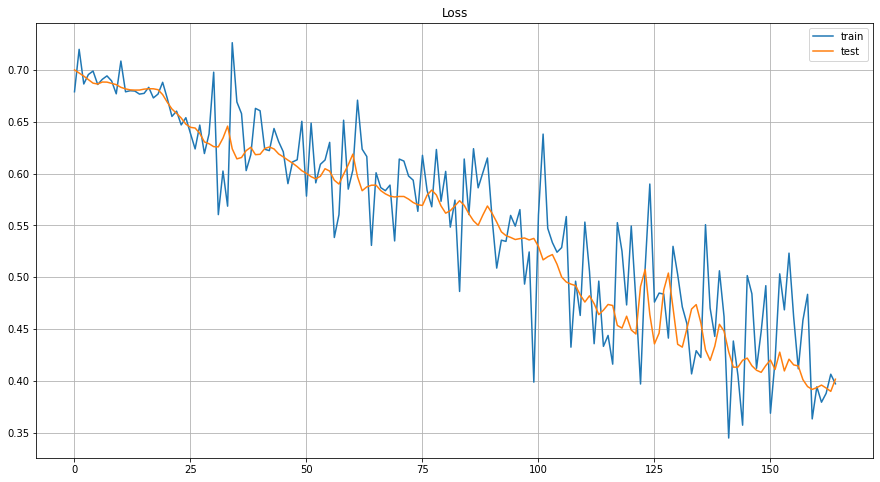

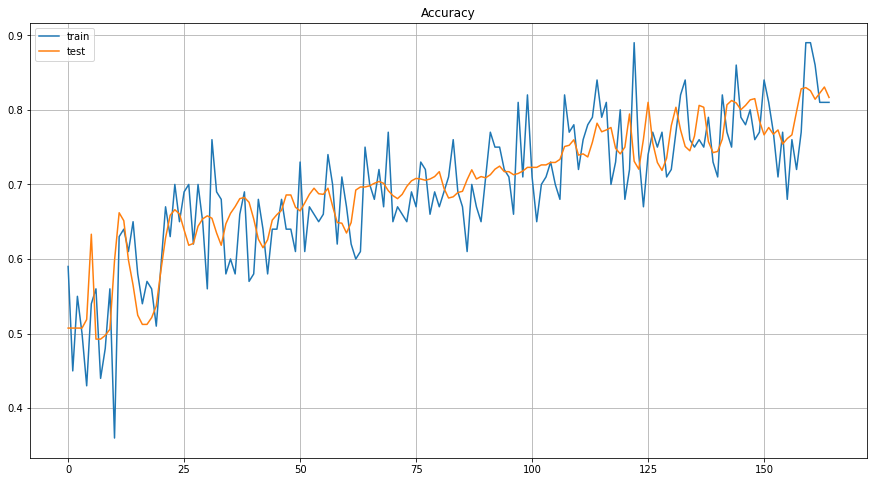

In [162]:
#!g1.4

length = 165
plt.figure(figsize=(15, 8))
plt.plot(train_loss[:length], label='train')
plt.plot(test_loss[:length], label='test')
plt.legend()
plt.grid()
plt.title('Loss')
plt.savefig('loss')
plt.figure(figsize=(15, 8))
plt.plot(train_acc[:length], label='train')
plt.plot(test_acc[:length], label='test')
plt.legend()
plt.grid()
plt.title('Accuracy')
plt.savefig('accuracy')
plt.show()

In [130]:
#!g1.4
model_name = 'classifier'
path = f'./Models/{model_name}'
with open (path, 'wb') as f:
    torch.save(model.state_dict(), f)

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:811: UserWarning: The following variables cannot be serialized: f
  warnings.warn(message)


Проверим загрузку

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/too

size 1
elem tensor([], device='cuda:0', size=(0, 10), grad_fn=<SliceBackward>)
size 1
elem tensor([], device='cuda:0', size=(0, 10), grad_fn=<SliceBackward>)


(103, 0, 0)

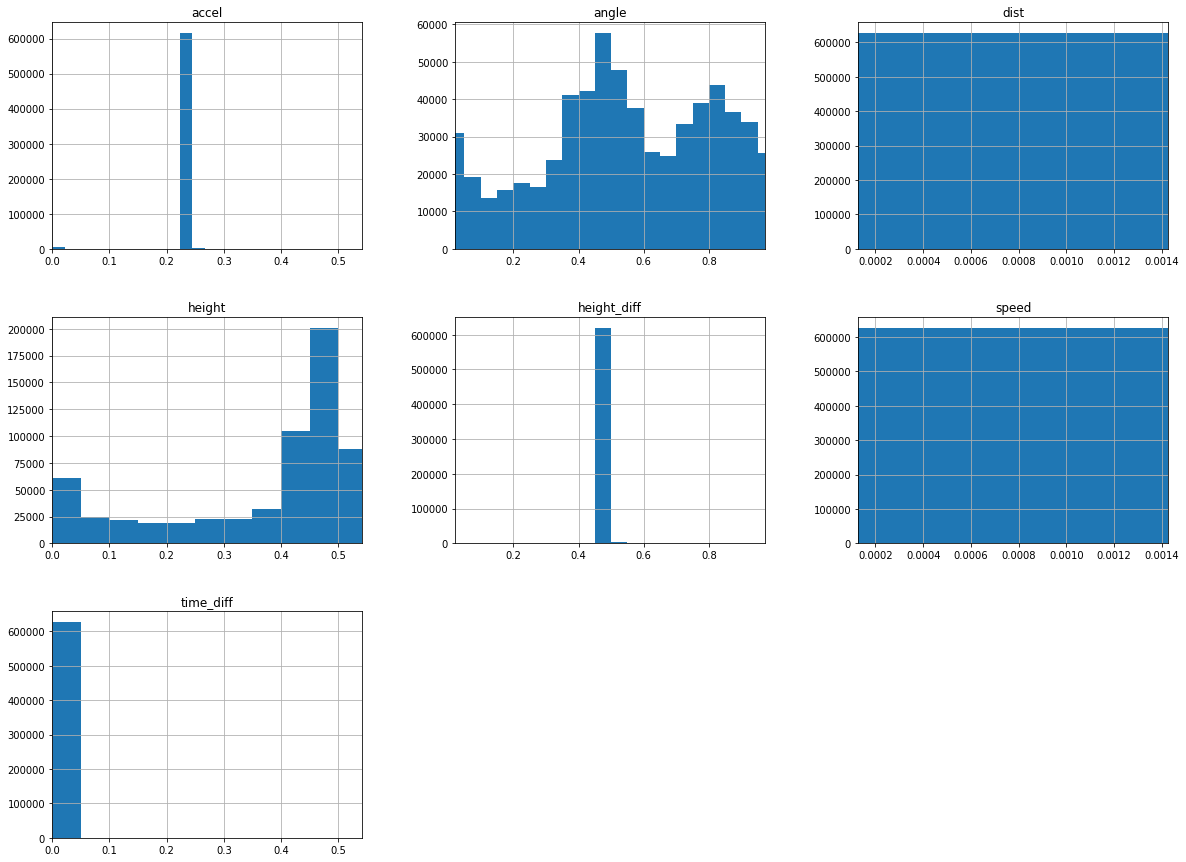

In [253]:
#!g1.4
import importlib
import utils
importlib.reload(utils)

index = 1
tracks = bad_tracks[index]
utils.predict(tracks)

In [254]:
#!g1.4
pd.read_csv(f'./Data/BadTracks{tracks}').shape[0]

308521

In [255]:
#!g1.4
pd.read_csv(f'./Data/GoodTracks{tracks}').shape[0]

320058